#A Study On Various Optimization Algorithms
By **Dibyendu Das** \\
**M.Sc Big Data Analytics** \\
**Ramakrishna Mission Vivekananda Educational and Research Institute Research institution in Howrah, West Bengal** \\
**Under The Guidence Of Mrinmay Maharaj**


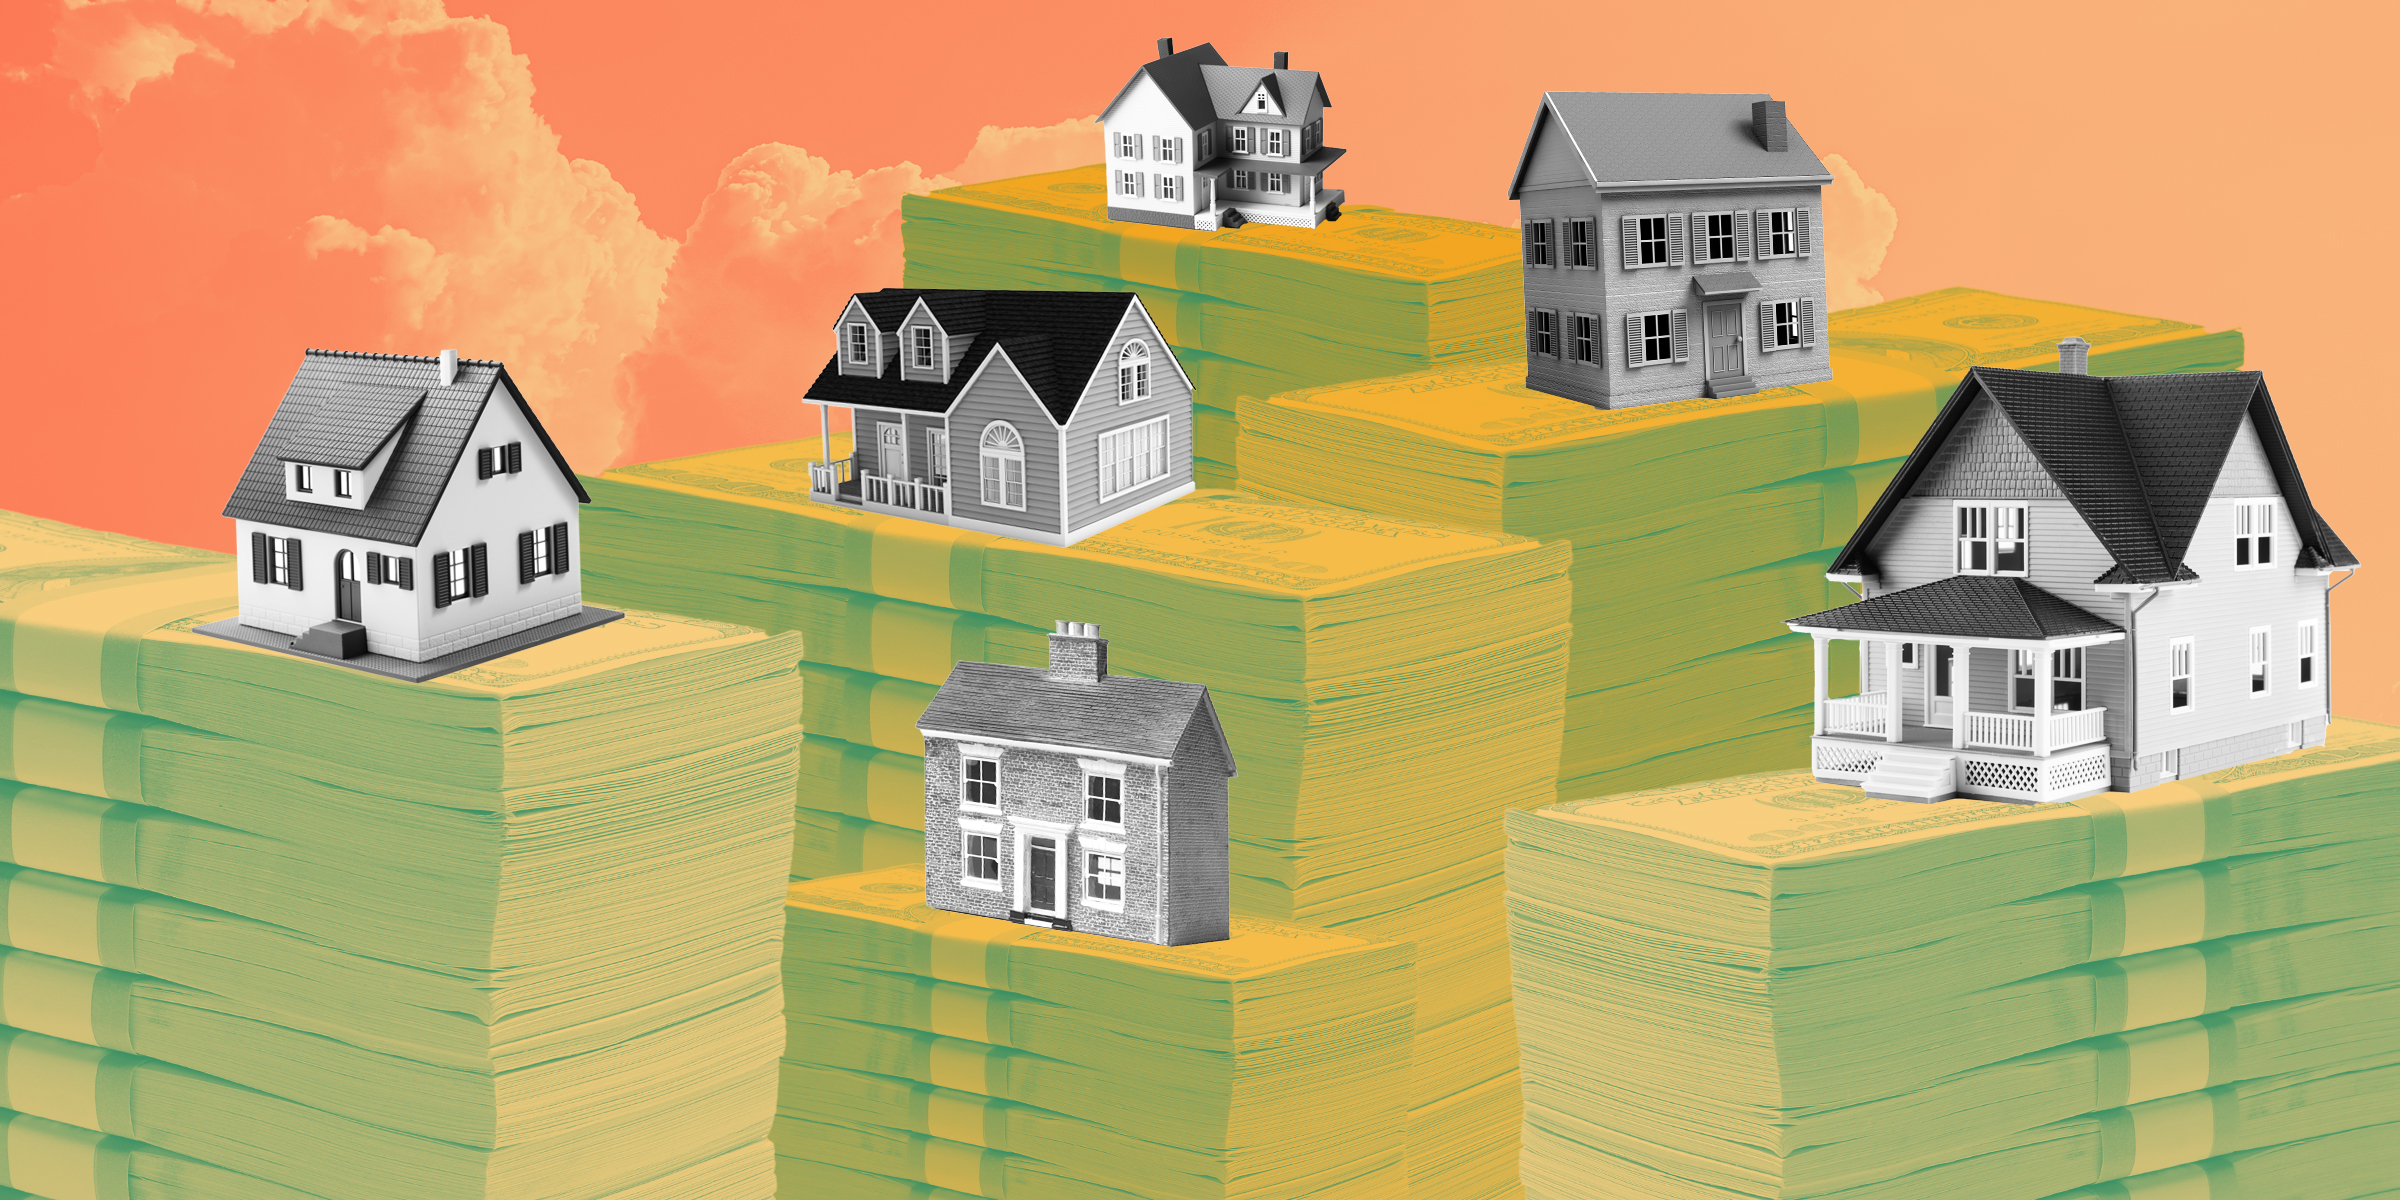

In this notebook  we are going to a neural network to predict whether the house price is below or above median value. We will go through the following in this notebook:

- Exploring and Processing the Data
- Building and Training our Neural Network
- Anlysis of Loss and Accuracy
- Adding Regularization to our Neural Network

# Exploring and Processing the Data

We first have to read in the CSV file that we've been given. We'll use a package called pandas for that:

In [ ]:
import pandas as pd
from sklearn import preprocessing
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Dropout
from keras import regularizers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/OPTAL  PROJECT/housepricedata.csv')

In [ ]:
df

LotArea  OverallQual  ...  GarageArea  AboveMedianPrice
0        8450            7  ...         548                 1
1        9600            6  ...         460                 1
2       11250            7  ...         608                 1
3        9550            7  ...         642                 0
4       14260            8  ...         836                 1
...       ...          ...  ...         ...               ...
1455     7917            6  ...         460                 1
1456    13175            6  ...         500                 1
1457     9042            7  ...         252                 1
1458     9717            5  ...         240                 0
1459     9937            5  ...         276                 0

[1460 rows x 11 columns]

In [ ]:
len(df)

1460

Text(0, 0.5, 'Frequency')

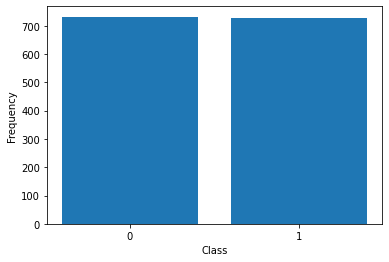

In [ ]:
plt.bar(['0' , '1'],list(df["AboveMedianPrice"].value_counts().values))
plt.xlabel("Class")
plt.ylabel("Frequency")

The dataset that we have now is in what we call a pandas dataframe. To convert it to an array, simply access its values:

In [ ]:
dataset = df.values
dataset

array([[ 8450,     7,     5, ...,     0,   548,     1],
       [ 9600,     6,     8, ...,     1,   460,     1],
       [11250,     7,     5, ...,     1,   608,     1],
       ...,
       [ 9042,     7,     9, ...,     2,   252,     1],
       [ 9717,     5,     6, ...,     0,   240,     0],
       [ 9937,     5,     6, ...,     0,   276,     0]])

Now, we split the dataset into our input features and the label we wish to predict.

In [ ]:
X = dataset[:,0:10]
Y = dataset[:,10]

Normalizing our data is very important, as we want the input features to be on the same order of magnitude to make our training easier. We'll use a min-max scaler from scikit-learn which scales our data to be between 0 and 1.

In [ ]:
from sklearn import preprocessing

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)

In [ ]:
X_scale

array([[0.0334198 , 0.66666667, 0.5       , ..., 0.5       , 0.        ,
        0.3864598 ],
       [0.03879502, 0.55555556, 0.875     , ..., 0.33333333, 0.33333333,
        0.32440056],
       [0.04650728, 0.66666667, 0.5       , ..., 0.33333333, 0.33333333,
        0.42877292],
       ...,
       [0.03618687, 0.66666667, 1.        , ..., 0.58333333, 0.66666667,
        0.17771509],
       [0.03934189, 0.44444444, 0.625     , ..., 0.25      , 0.        ,
        0.16925247],
       [0.04037019, 0.44444444, 0.625     , ..., 0.33333333, 0.        ,
        0.19464034]])

Lastly, we wish to set aside some parts of our dataset for a validation set and a test set. We use the function train_test_split from scikit-learn to do that.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y, test_size=0.3)

In [ ]:
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

In [ ]:
print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(1022, 10) (219, 10) (219, 10) (1022,) (219,) (219,)


# Building and Training Our First Neural Network

We will be using Keras to build our architecture. Let's import the code from Keras that we will need to use:

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

We will be using the Sequential model, which means that we merely need to describe the layers above in sequence. Our neural network has three layers:

- Hidden layer 1: 30 neurons, ReLU activation
- Hidden layer 2: 30 neurons, ReLU activation
- Output Layer: 1 neuron, Sigmoid activation

In [ ]:
model_1 = Sequential([
    Dense(32, activation='relu', input_shape=(10,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])

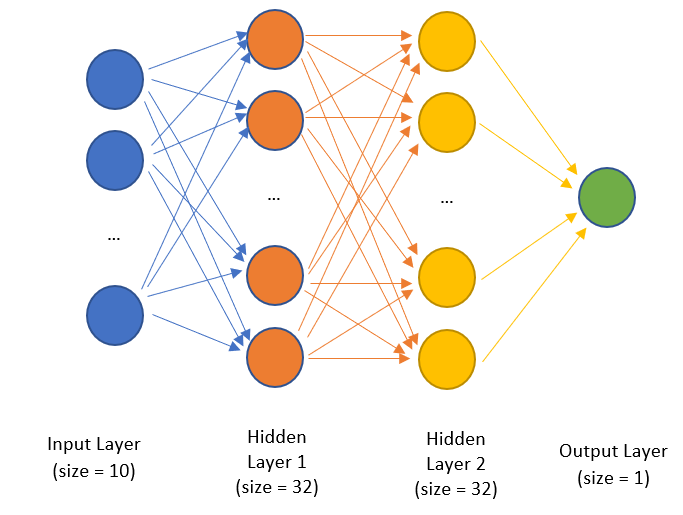

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                352       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


Now that we've got our architecture specified, we need to find the best numbers for it. Before we start our training, we have to configure the model by
- Telling it what algorithm you want to use to do the optimization 
- Telling it what loss function to use (for binary classification, we will use binary cross entropy)
- Telling it what other metrics you want to track apart from the loss function (we want to track accuracy as well)

We do so below:

#OPTIMIZER : SGD

## Stochastic Gradient Updates

In deep learning, the objective function is usually the average of the loss functions for each example in the training dataset.
Given a training dataset of $n$ examples,
we assume that $f_i(\mathbf{x})$ is the loss function
with respect to the training example of index $i$,
where $\mathbf{x}$ is the parameter vector.
Then we arrive at the objective function

$$f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\mathbf{x}).$$

The gradient of the objective function at $\mathbf{x}$ is computed as

$$\nabla f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}).$$

If gradient descent is used, the computational cost for each independent variable iteration is $\mathcal{O}(n)$, which grows linearly with $n$. Therefore, when the  training dataset is larger, the cost of gradient descent for each iteration will be higher.

Stochastic gradient descent (SGD) reduces computational cost at each iteration. At each iteration of stochastic gradient descent, we uniformly sample an index $i\in\{1,\ldots, n\}$ for data examples at random, and compute the gradient $\nabla f_i(\mathbf{x})$ to update $\mathbf{x}$:

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f_i(\mathbf{x}),$$

where $\eta$ is the learning rate. We can see that the computational cost for each iteration drops from $\mathcal{O}(n)$ of the gradient descent to the constant $\mathcal{O}(1)$. Moreover, we want to emphasize that the stochastic gradient $\nabla f_i(\mathbf{x})$ is an unbiased estimate of the full gradient $\nabla f(\mathbf{x})$ because

$$\mathbb{E}_i \nabla f_i(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}) = \nabla f(\mathbf{x}).$$

This means that, on average, the stochastic gradient is a good estimate of the gradient.

#SGD =  0.001

In [ ]:
import tensorflow as tf

In [ ]:
sgd = tf.keras.optimizers.SGD(learning_rate= 0.5)

In [ ]:
model_1.compile(optimizer = "sgd",
              loss='binary_crossentropy',
              metrics=['accuracy'])

Training on the data is pretty straightforward and requires us to write one line of code. The function is called 'fit' as we are fitting the parameters to the data. We specify:
- what data we are training on, which is X_train and Y_train
- the size of our mini-batch 
- how long we want to train it for (epochs)
- what our validation data is so that the model will tell us how we are doing on the validation data at each point.

This function will output a history, which we save under the variable hist. We'll use this variable a little later.

In [ ]:
hist = model_1.fit(X_train, Y_train,
          batch_size=32, epochs=150,
          validation_data=(X_val, Y_val))

Epoch 1/150
32/32 [==============================] - 1s 8ms/step - loss: 0.6926 - accuracy: 0.4951 - val_loss: 0.6864 - val_accuracy: 0.5205
Epoch 2/150
32/32 [==============================] - 0s 2ms/step - loss: 0.6830 - accuracy: 0.5509 - val_loss: 0.6797 - val_accuracy: 0.5114
Epoch 3/150
32/32 [==============================] - 0s 2ms/step - loss: 0.6749 - accuracy: 0.5401 - val_loss: 0.6732 - val_accuracy: 0.4977
Epoch 4/150
32/32 [==============================] - 0s 2ms/step - loss: 0.6676 - accuracy: 0.5499 - val_loss: 0.6679 - val_accuracy: 0.4932
Epoch 5/150
32/32 [==============================] - 0s 2ms/step - loss: 0.6622 - accuracy: 0.5558 - val_loss: 0.6634 - val_accuracy: 0.5251
Epoch 6/150
32/32 [==============================] - 0s 2ms/step - loss: 0.6576 - accuracy: 0.5636 - val_loss: 0.6589 - val_accuracy: 0.5662
Epoch 7/150
32/32 [==============================] - 0s 3ms/step - loss: 0.6529 - accuracy: 0.5910 - val_loss: 0.6542 - val_accuracy: 0.6438
Epoch 8/150
3

Evaluating our data on the test set:

In [ ]:
model_1.evaluate(X_test, Y_test)

7/7 [==============================] - 0s 2ms/step - loss: 0.2218 - accuracy: 0.9087


[0.22180122137069702, 0.9086757898330688]

# Visualizing Loss and Accuracy of SGD

Import the relevant package we need to do the visualization

#tf.GradientTape : Record operations for automatic differentiation.

In [ ]:
def gradient(model, x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        loss = model(x_tensor)
    return t.gradient(loss, x_tensor).numpy()

In [ ]:
l = gradient(model_1 , X_train)

In [ ]:
grad = []
for i in l :
  
  grad.append(np.linalg.norm(i))

Text(0.5, 1.0, 'Density curve of norm of sgd')

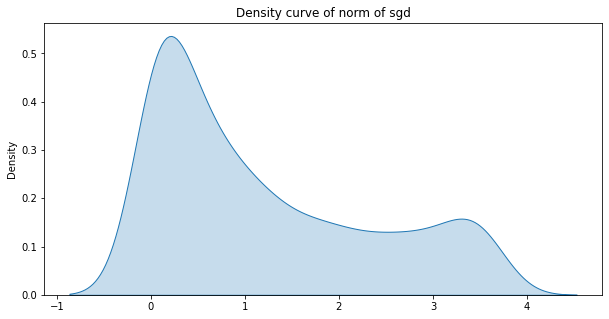

In [ ]:
plt.figure(figsize= (10,5))
sns.kdeplot(grad , fill=True )
plt.title("Density curve of norm of sgd")

We want to visualize the training loss and the validation loss like this:

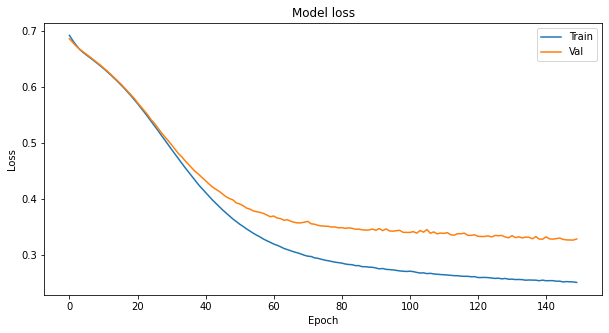

In [ ]:
plt.figure(figsize= (10,5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

We can also visualize the training accuracy and the validation accuracy like this:

In [ ]:
hist.history['val_accuracy']

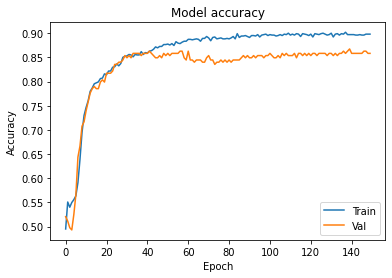

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [ ]:
pd.DataFrame(np.array([["Model 1","SGD" ,0.2515,0.8982,0.3291,0.8584 , 0.9086 ,125]]) ,columns=['Model', 'Method', 'Training Loss' ,'Training Accuracy','Validation Loss','Validation Accuracy','Test Accuracy',"Stable"])

Model Method Training Loss  ... Validation Accuracy Test Accuracy Stable
0  Model 1    SGD        0.2515  ...              0.8584        0.9086    125

[1 rows x 8 columns]

#OPTIMIZER : RMSprop

# RMSProp

## The Algorithm

Let us write out the equations in detail.

$$\begin{aligned}
    \mathbf{s}_t & \leftarrow \gamma \mathbf{s}_{t-1} + (1 - \gamma) \mathbf{g}_t^2, \\
    \mathbf{x}_t & \leftarrow \mathbf{x}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \odot \mathbf{g}_t.
\end{aligned}$$

The constant $\epsilon > 0$ is typically set to $10^{-6}$ to ensure that we do not suffer from division by zero or overly large step sizes. Given this expansion we are now free to control the learning rate $\eta$ independently of the scaling that is applied on a per-coordinate basis. In terms of leaky averages we can apply the same reasoning as previously applied in the case of the momentum method. Expanding the definition of $\mathbf{s}_t$ yields

$$
\begin{aligned}
\mathbf{s}_t & = (1 - \gamma) \mathbf{g}_t^2 + \gamma \mathbf{s}_{t-1} \\
& = (1 - \gamma) \left(\mathbf{g}_t^2 + \gamma \mathbf{g}_{t-1}^2 + \gamma^2 \mathbf{g}_{t-2} + \ldots, \right).
\end{aligned}
$$

As before in :numref:`sec_momentum` we use $1 + \gamma + \gamma^2 + \ldots, = \frac{1}{1-\gamma}$. Hence the sum of weights is normalized to $1$ with a half-life time of an observation of $\gamma^{-1}$. Let us visualize the weights for the past 40 time steps for various choices of $\gamma$. \\

**The RMSprop optimizer is similar to the gradient descent algorithm with momentum. The RMSprop optimizer restricts the oscillations in the vertical direction. Therefore, we can increase our learning rate and our algorithm could take larger steps in the horizontal direction converging faster. The difference between RMSprop and gradient descent is on how the gradients are calculated**. . \\


RMSprop is a gradient-based optimization technique used in training neural networks. It was proposed by the father of back-propagation, Geoffrey Hinton. Gradients of very complex functions like neural networks have a tendency to either vanish or explode as the data propagates through the function (refer to vanishing gradients problem). Rmsprop was developed as a stochastic technique for mini-batch learning.
RMSprop deals with the above issue by using a moving average of squared gradients to normalize the gradient. This normalization balances the step size (momentum), decreasing the step for large gradients to avoid exploding and increasing the step for small gradients to avoid vanishing.
Simply put, RMSprop uses an adaptive learning rate instead of treating the learning rate as a hyperparameter. This means that the learning rate changes over time.


In [ ]:
model_11 = Sequential([
    Dense(32, activation='relu', input_shape=(10,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])

In [ ]:
rms = tf.keras.optimizers.RMSprop(
    learning_rate=0.001,
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07,
    centered=False,
    name="RMSprop",
)

In [ ]:
model_11.compile(optimizer = rms,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
hist = model_11.fit(X_train, Y_train,
          batch_size=32, epochs= 150,
          validation_data=(X_val, Y_val))

Epoch 1/150
32/32 [==============================] - 1s 7ms/step - loss: 0.6554 - accuracy: 0.6380 - val_loss: 0.6320 - val_accuracy: 0.7260
Epoch 2/150
32/32 [==============================] - 0s 3ms/step - loss: 0.6044 - accuracy: 0.7769 - val_loss: 0.5860 - val_accuracy: 0.7671
Epoch 3/150
32/32 [==============================] - 0s 3ms/step - loss: 0.5547 - accuracy: 0.7955 - val_loss: 0.5305 - val_accuracy: 0.8447
Epoch 4/150
32/32 [==============================] - 0s 3ms/step - loss: 0.5065 - accuracy: 0.8337 - val_loss: 0.4861 - val_accuracy: 0.8356
Epoch 5/150
32/32 [==============================] - 0s 2ms/step - loss: 0.4646 - accuracy: 0.8464 - val_loss: 0.4463 - val_accuracy: 0.8584
Epoch 6/150
32/32 [==============================] - 0s 2ms/step - loss: 0.4291 - accuracy: 0.8503 - val_loss: 0.4161 - val_accuracy: 0.8584
Epoch 7/150
32/32 [==============================] - 0s 3ms/step - loss: 0.4004 - accuracy: 0.8581 - val_loss: 0.3958 - val_accuracy: 0.8539
Epoch 8/150
3

In [ ]:
model_11.evaluate(X_test, Y_test)

7/7 [==============================] - 0s 3ms/step - loss: 0.2698 - accuracy: 0.8858


[0.26982784271240234, 0.8858447670936584]

# Visualizing Loss and Accuracy of RMSprop (lr = 0.001)

In [ ]:
def gradient(model, x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        loss = model(x_tensor)
    return t.gradient(loss, x_tensor).numpy()
l = gradient(model_11 , X_train)
grad = []
for i in l :
  grad.append(np.linalg.norm(i))

In [ ]:
import seaborn as sns

Text(0.5, 1.0, 'Density curve of norm of RMSprop')

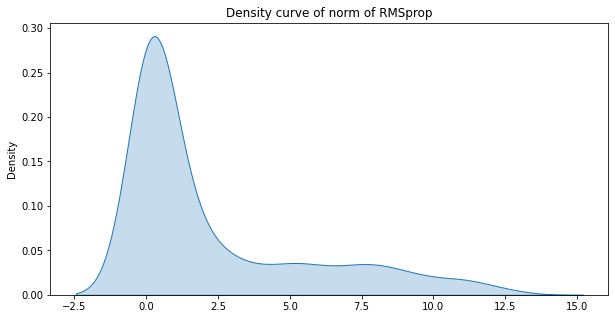

In [ ]:
plt.figure(figsize = (10,5))
sns.kdeplot(grad , fill=True)
plt.title("Density curve of norm of RMSprop")

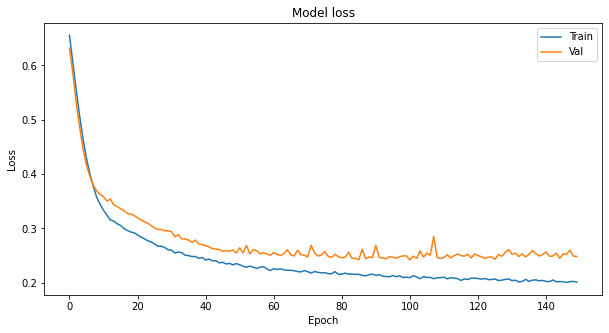

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

We can also visualize the training accuracy and the validation accuracy like this:

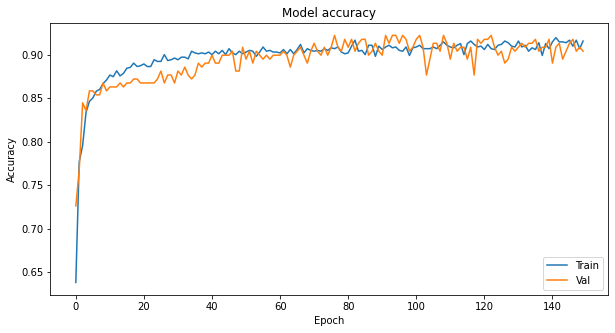

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [ ]:
pd.DataFrame(np.array([["Model 1","SGD" ,0.2515,0.8982,0.3291,0.8584 , 0.9086 ,125]
                       ,["Model 1","RMSprop",0.2010 ,0.9159 ,0.2483 ,0.9041,0.88584,40]]) ,columns=['Model', 'Method', 'Training Loss' ,'Training Accuracy','Validation Loss','Validation Accuracy','Test Accuracy',"Stable"])

Model   Method Training Loss  ... Validation Accuracy Test Accuracy Stable
0  Model 1      SGD        0.2515  ...              0.8584        0.9086    125
1  Model 1  RMSprop         0.201  ...              0.9041       0.88584     40

[2 rows x 8 columns]

##OPTIMIZER : ADAM (lr = 0.001)

**Adam can be looked at as a combination of RMSprop and Stochastic Gradient Descent with momentum**. **It uses the squared gradients to scale the learning rate like RMSprop and it takes advantage of momentum by using moving average of the gradient instead of gradient itself like SGD with momentum**. \\
**Actual step size taken by the Adam in each iteration is approximately bounded the step size hyper-parameter**. This property add intuitive understanding to previous unintuitive learning rate hyper-parameter. \\
Step size of Adam update rule is invariant to the magnitude of the gradient, which helps a lot when going through areas with tiny gradients (such as saddle points or ravines). In these areas SGD struggles to quickly navigate through them.  \\ 
However, after a while people started noticing that despite superior training time, Adam in some areas does not converge to an optimal solution, so for some tasks (such as image classification on popular CIFAR datasets) state-of-the-art results are still only achieved by applying SGD with momentum. More than that **Wilson et. al [9]** showed in their paper **‘The marginal value of adaptive gradient methods in machine learning’** that adaptive methods (such as Adam or Adadelta) do not generalize as well as SGD with momentum when tested on a diverse set of deep learning tasks, discouraging people to use popular optimization algorithms. A lot of research has been done since to analyze the poor generalization of Adam trying to get it to close the gap with SGD.

In [ ]:
model_12 = Sequential([
    Dense(32, activation='relu', input_shape=(10,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])

In [ ]:
model_12.compile(optimizer = "adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
hist = model_12.fit(X_train, Y_train,
          batch_size=16, epochs= 150,
          validation_data=(X_val, Y_val))

Epoch 1/150
64/64 [==============================] - 1s 4ms/step - loss: 0.6960 - accuracy: 0.5890 - val_loss: 0.6398 - val_accuracy: 0.8356
Epoch 2/150
64/64 [==============================] - 0s 2ms/step - loss: 0.5730 - accuracy: 0.8209 - val_loss: 0.5019 - val_accuracy: 0.8402
Epoch 3/150
64/64 [==============================] - 0s 2ms/step - loss: 0.4360 - accuracy: 0.8376 - val_loss: 0.4037 - val_accuracy: 0.8721
Epoch 4/150
64/64 [==============================] - 0s 2ms/step - loss: 0.3611 - accuracy: 0.8640 - val_loss: 0.3766 - val_accuracy: 0.8539
Epoch 5/150
64/64 [==============================] - 0s 3ms/step - loss: 0.3282 - accuracy: 0.8601 - val_loss: 0.3493 - val_accuracy: 0.8676
Epoch 6/150
64/64 [==============================] - 0s 2ms/step - loss: 0.3143 - accuracy: 0.8611 - val_loss: 0.3335 - val_accuracy: 0.8767
Epoch 7/150
64/64 [==============================] - 0s 2ms/step - loss: 0.2978 - accuracy: 0.8767 - val_loss: 0.3263 - val_accuracy: 0.8767
Epoch 8/150
6

In [ ]:
model_12.evaluate(X_test, Y_test)

7/7 [==============================] - 0s 2ms/step - loss: 0.2814 - accuracy: 0.8858


[0.28137511014938354, 0.8858447670936584]

In [ ]:
def gradient(model, x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        loss = model(x_tensor)
    return t.gradient(loss, x_tensor).numpy()
l = gradient(model_12 , X_train)
grad = []
for i in l :
  grad.append(np.linalg.norm(i))

Text(0.5, 1.0, 'Density curve of norm of ADAM')

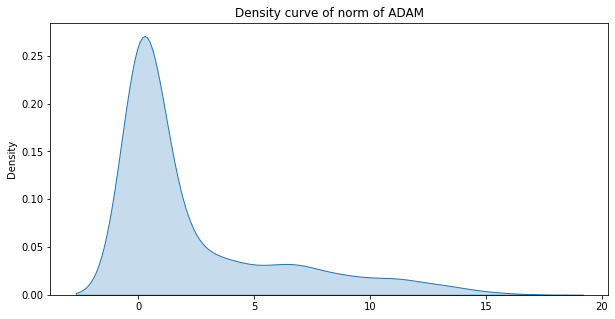

In [ ]:
plt.figure(figsize = (10,5))
sns.kdeplot(grad , fill=True)
plt.title("Density curve of norm of ADAM")

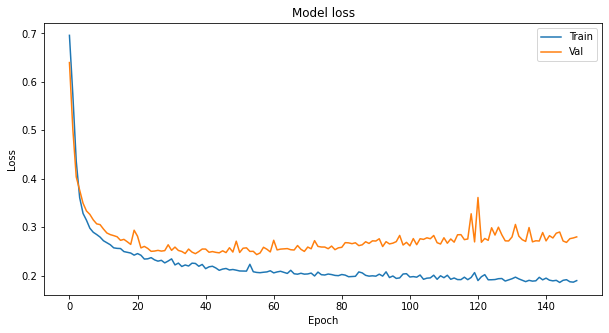

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

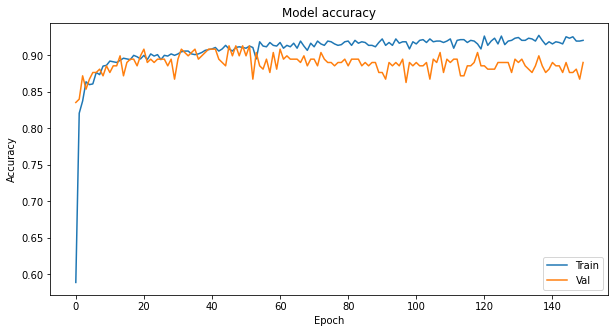

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [ ]:
pd.DataFrame(np.array([["Model 1","SGD" ,0.2515,0.8982,0.3291,0.8584 , 0.9086 ,125]
                       ,["Model 1","RMSprop",0.2010 ,0.9159 ,0.2483 ,0.9041,0.88584,40],
                        ["Model 1", "ADAM",0.1896 ,0.9207 ,0.2799 ,0.8904 , 0.8858,19]]) ,columns=['Model', 'Method', 'Training Loss' ,'Training Accuracy','Validation Loss','Validation Accuracy','Test Accuracy',"Stable"])

Model   Method Training Loss  ... Validation Accuracy Test Accuracy Stable
0  Model 1      SGD        0.2515  ...              0.8584        0.9086    125
1  Model 1  RMSprop         0.201  ...              0.9041       0.88584     40
2  Model 1     ADAM        0.1896  ...              0.8904        0.8858     19

[3 rows x 8 columns]

#OPTIMIZER :ADAGRAD (lr = 0.001)




Whatever the optimizer we learned till SGD with momentum, the learning rate remains constant. In Adagrad optimizer, there is no momentum concept so, it is much simpler compared to SGD with momentum.
**The idea behind Adagrad is to use different learning rates for each parameter base on iteration. The reason behind the need for different learning rates is that the learning rate for sparse features parameters needs to be higher compare to the dense features parameter because the frequency of occurrence of sparse features is lower**.
![picture]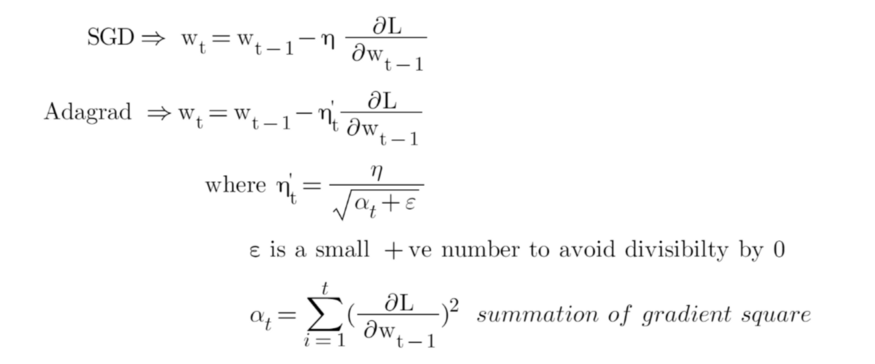 

In the above Adagrad optimizer equation, the learning rate has been modified in such a way that it will automatically decrease because the summation of the previous gradient square will always keep on increasing after every time step

In [ ]:
model_13 = Sequential([
    Dense(32, activation='relu', input_shape=(10,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])

In [ ]:
adagrad = tf.keras.optimizers.Adagrad(
     learning_rate=0.001,
     initial_accumulator_value=0,
     epsilon=1e-07,
     name="Adagrad"
 ) 

In [ ]:
model_13.compile(optimizer = adagrad,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
hist = model_13.fit(X_train, Y_train,
          batch_size=32, epochs= 150,
          validation_data=(X_val, Y_val))

Epoch 1/150
32/32 [==============================] - 1s 7ms/step - loss: 0.7026 - accuracy: 0.4843 - val_loss: 0.6892 - val_accuracy: 0.5753
Epoch 2/150
32/32 [==============================] - 0s 3ms/step - loss: 0.6834 - accuracy: 0.6174 - val_loss: 0.6757 - val_accuracy: 0.6986
Epoch 3/150
32/32 [==============================] - 0s 2ms/step - loss: 0.6704 - accuracy: 0.7241 - val_loss: 0.6656 - val_accuracy: 0.7078
Epoch 4/150
32/32 [==============================] - 0s 2ms/step - loss: 0.6604 - accuracy: 0.7299 - val_loss: 0.6577 - val_accuracy: 0.7169
Epoch 5/150
32/32 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.7339 - val_loss: 0.6512 - val_accuracy: 0.7169
Epoch 6/150
32/32 [==============================] - 0s 3ms/step - loss: 0.6462 - accuracy: 0.7329 - val_loss: 0.6455 - val_accuracy: 0.7169
Epoch 7/150
32/32 [==============================] - 0s 3ms/step - loss: 0.6407 - accuracy: 0.7407 - val_loss: 0.6404 - val_accuracy: 0.7215
Epoch 8/150
3

In [ ]:
model_13.evaluate(X_test, Y_test)

7/7 [==============================] - 0s 2ms/step - loss: 0.3997 - accuracy: 0.8630


[0.3997288644313812, 0.8630136847496033]

In [ ]:
def gradient(model, x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        loss = model(x_tensor)
    return t.gradient(loss, x_tensor).numpy()
l = gradient(model_13 , X_train)
grad = []
for i in l :
  grad.append(np.linalg.norm(i))

Text(0.5, 1.0, 'Density curve of norm of ADAGRAD')

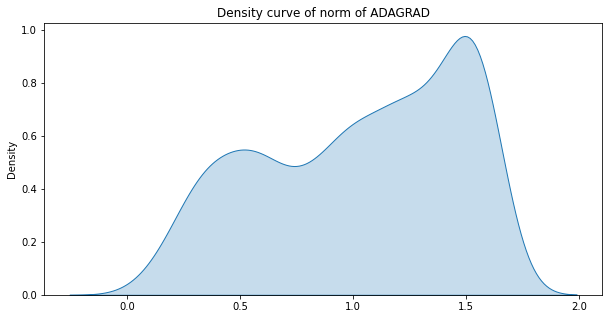

In [ ]:
plt.figure(figsize = (10,5))
sns.kdeplot(grad , fill=True)
plt.title("Density curve of norm of ADAGRAD")

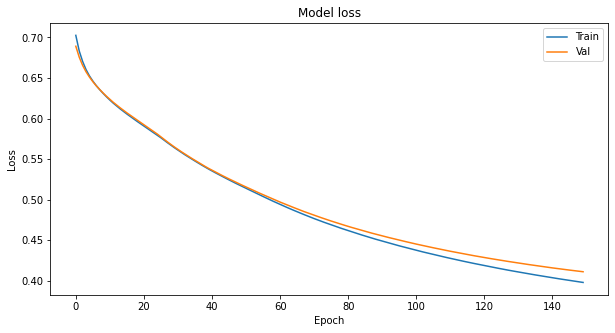

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

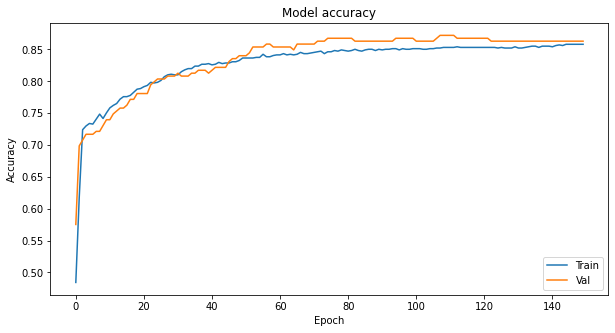

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [ ]:
pd.DataFrame(np.array([["Model 1","SGD" ,0.2515,0.8982,0.3291,0.8584 , 0.9086 ,125]
                       ,["Model 1","RMSprop",0.2010 ,0.9159 ,0.2483 ,0.9041,0.88584,40],
                        ["Model 1", "ADAM",0.1896 ,0.9207 ,0.2799 ,0.8904 , 0.8858,19],["Model 1", "ADAGRAD",0.3980 ,0.8581 ,0.4111 ,0.8630 ,0.8683,140]]) ,columns=['Model', 'Method', 'Training Loss' ,'Training Accuracy','Validation Loss','Validation Accuracy','Test Accuracy',"Stable"])

Model   Method Training Loss  ... Validation Accuracy Test Accuracy Stable
0  Model 1      SGD        0.2515  ...              0.8584        0.9086    125
1  Model 1  RMSprop         0.201  ...              0.9041       0.88584     40
2  Model 1     ADAM        0.1896  ...              0.8904        0.8858     19
3  Model 1  ADAGRAD         0.398  ...               0.863        0.8683    140

[4 rows x 8 columns]

# Adding Regularization to our Neural Network

We'll train a model which will overfit, which we call Model 2. This might take a few minutes.

##OPTIMIZER : ADAM


In [ ]:
model_2 = Sequential([
    Dense(1000, activation='relu', input_shape=(10,)),
    Dense(1000, activation='relu'),
    Dense(1000, activation='relu'),
    Dense(1000, activation='relu'),
    Dense(1, activation='sigmoid'),
])
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
hist_2 = model_2.fit(X_train, Y_train,
          batch_size=32, epochs=100,
          validation_data=(X_val, Y_val))

Epoch 1/100
32/32 [==============================] - 2s 41ms/step - loss: 0.4753 - accuracy: 0.7896 - val_loss: 0.3823 - val_accuracy: 0.8584
Epoch 2/100
32/32 [==============================] - 1s 37ms/step - loss: 0.3195 - accuracy: 0.8542 - val_loss: 0.3449 - val_accuracy: 0.8630
Epoch 3/100
32/32 [==============================] - 1s 36ms/step - loss: 0.2889 - accuracy: 0.8728 - val_loss: 0.3164 - val_accuracy: 0.8584
Epoch 4/100
32/32 [==============================] - 1s 37ms/step - loss: 0.3098 - accuracy: 0.8591 - val_loss: 0.3700 - val_accuracy: 0.8265
Epoch 5/100
32/32 [==============================] - 1s 36ms/step - loss: 0.2789 - accuracy: 0.8924 - val_loss: 0.2722 - val_accuracy: 0.8950
Epoch 6/100
32/32 [==============================] - 1s 36ms/step - loss: 0.2573 - accuracy: 0.8963 - val_loss: 0.2820 - val_accuracy: 0.8995
Epoch 7/100
32/32 [==============================] - 1s 36ms/step - loss: 0.2491 - accuracy: 0.8894 - val_loss: 0.2483 - val_accuracy: 0.8995
Epoch 

In [ ]:
model_2.evaluate(X_test, Y_test)

7/7 [==============================] - 0s 8ms/step - loss: 0.4590 - accuracy: 0.8767


[0.45902562141418457, 0.8767123222351074]

Let's do the same visualization to see what overfitting looks like in terms of the loss and accuracy.

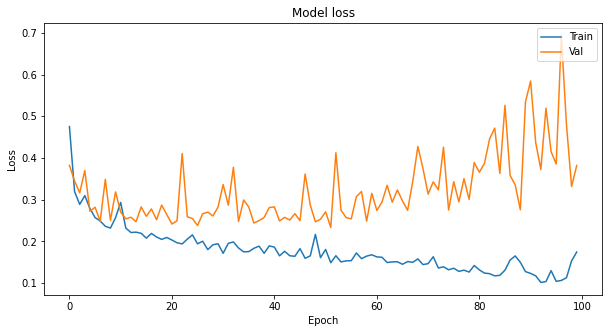

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(hist_2.history['loss'])
plt.plot(hist_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

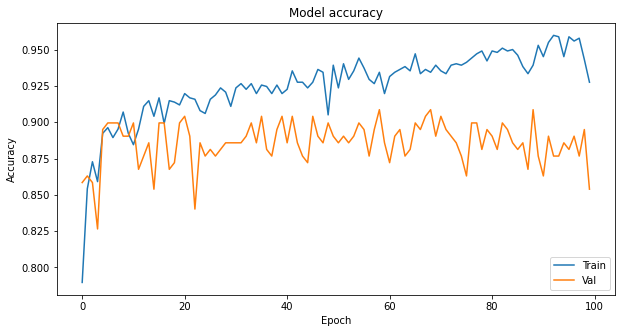

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(hist_2.history['accuracy'])
plt.plot(hist_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [ ]:
def gradient(model, x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        loss = model(x_tensor)
    return t.gradient(loss, x_tensor).numpy()
l = gradient(model_2 , X_train)
grad = []
for i in l :
  grad.append(np.linalg.norm(i))

Text(0.5, 1.0, 'Density curve of norm of ADAM')

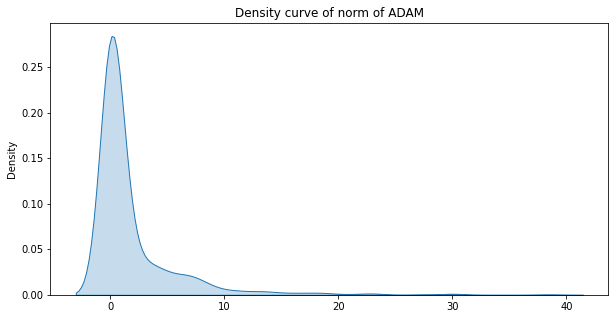

In [ ]:
plt.figure(figsize = (10,5))
sns.kdeplot(grad , fill=True)
plt.title("Density curve of norm of ADAM")

In [ ]:
pd.DataFrame(np.array([["Model 1","SGD" ,0.2515,0.8982,0.3291,0.8584 , 0.9086 ,125]
                       ,["Model 1","RMSprop",0.2010 ,0.9159 ,0.2483 ,0.9041,0.88584,40],
                        ["Model 1", "ADAM",0.1896 ,0.9207 ,0.2799 ,0.8904 , 0.8858,19],["Model 1", "ADAGRAD",0.3980 ,0.8581 ,0.4111 ,0.8630 ,0.8683,140],
                       ["Model 2","ADAM" , 0.1745, 0.9276 ,0.3820 ,0.8539,0.876712,66]
                       ]) ,columns=['Model', 'Method', 'Training Loss' ,'Training Accuracy','Validation Loss','Validation Accuracy','Test Accuracy',"Stable"])

Model   Method Training Loss  ... Validation Accuracy Test Accuracy Stable
0  Model 1      SGD        0.2515  ...              0.8584        0.9086    125
1  Model 1  RMSprop         0.201  ...              0.9041       0.88584     40
2  Model 1     ADAM        0.1896  ...              0.8904        0.8858     19
3  Model 1  ADAGRAD         0.398  ...               0.863        0.8683    140
4  Model 2     ADAM        0.1745  ...              0.8539      0.876712     66

[5 rows x 8 columns]

#OPTIMIZER : ADAGRAD

In [ ]:
model_21 = Sequential([
    Dense(1000, activation='relu', input_shape=(10,)),
    Dense(1000, activation='relu'),
    Dense(1000, activation='relu'),
    Dense(1000, activation='relu'),
    Dense(1, activation='sigmoid'),
])
model_21.compile(optimizer= adagrad,
              loss='binary_crossentropy',
              metrics=['accuracy'])
hist_2 = model_21.fit(X_train, Y_train,
          batch_size=32, epochs=100,
          validation_data=(X_val, Y_val))

Epoch 1/100
32/32 [==============================] - 2s 40ms/step - loss: 0.4889 - accuracy: 0.7671 - val_loss: 0.3727 - val_accuracy: 0.8584
Epoch 2/100
32/32 [==============================] - 1s 34ms/step - loss: 0.3462 - accuracy: 0.8513 - val_loss: 0.3571 - val_accuracy: 0.8630
Epoch 3/100
32/32 [==============================] - 1s 34ms/step - loss: 0.3298 - accuracy: 0.8581 - val_loss: 0.3448 - val_accuracy: 0.8676
Epoch 4/100
32/32 [==============================] - 1s 35ms/step - loss: 0.3086 - accuracy: 0.8669 - val_loss: 0.3388 - val_accuracy: 0.8721
Epoch 5/100
32/32 [==============================] - 1s 34ms/step - loss: 0.2948 - accuracy: 0.8777 - val_loss: 0.3204 - val_accuracy: 0.8904
Epoch 6/100
32/32 [==============================] - 1s 33ms/step - loss: 0.2811 - accuracy: 0.8787 - val_loss: 0.3435 - val_accuracy: 0.8539
Epoch 7/100
32/32 [==============================] - 1s 34ms/step - loss: 0.2771 - accuracy: 0.8777 - val_loss: 0.3324 - val_accuracy: 0.8721
Epoch 

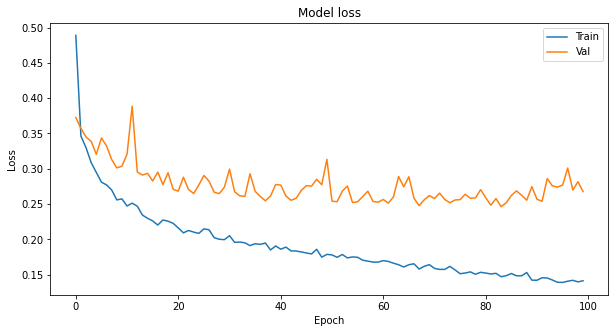

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(hist_2.history['loss'])
plt.plot(hist_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

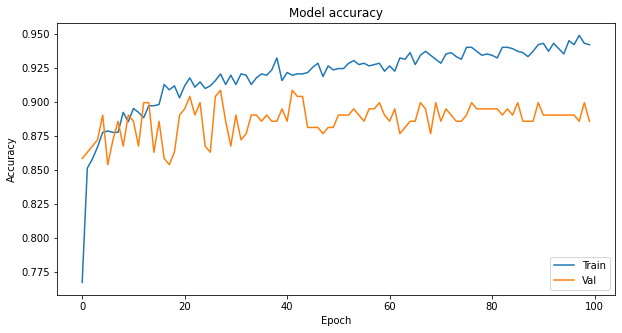

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(hist_2.history['accuracy'])
plt.plot(hist_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [ ]:
def gradient(model, x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        loss = model(x_tensor)
    return t.gradient(loss, x_tensor).numpy()
l = gradient(model_21 , X_train)
grad = []
for i in l :
  grad.append(np.linalg.norm(i))

Text(0.5, 1.0, 'Density curve of norm of ADAGRAD')

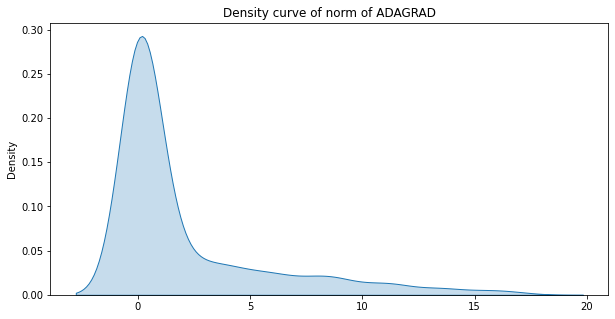

In [ ]:
plt.figure(figsize = (10,5))
sns.kdeplot(grad , fill=True)
plt.title("Density curve of norm of ADAGRAD")


In [ ]:
model_21.evaluate(X_test, Y_test)

7/7 [==============================] - 0s 7ms/step - loss: 0.5734 - accuracy: 0.8858


[0.5733646154403687, 0.8858447670936584]

In [ ]:
pd.DataFrame(np.array([["Model 1","SGD" ,0.2515,0.8982,0.3291,0.8584 , 0.9086 ,125]
                       ,["Model 1","RMSprop",0.2010 ,0.9159 ,0.2483 ,0.9041,0.88584,40],
                        ["Model 1", "ADAM",0.1896 ,0.9207 ,0.2799 ,0.8904 , 0.8858,19],["Model 1", "ADAGRAD",0.3980 ,0.8581 ,0.4111 ,0.8630 ,0.8683,140],
                       ["Model 2","ADAM" , 0.1745, 0.9276 ,0.3820 ,0.8539,0.876712,66],
                       ["Model 2","ADAGRAD" ,0.1414 ,0.9423, 0.2676 , 0.8858 ,0.8868,60]
                       ]) ,columns=['Model', 'Method', 'Training Loss' ,'Training Accuracy','Validation Loss','Validation Accuracy','Test Accuracy',"Stable"])

Model   Method Training Loss  ... Validation Accuracy Test Accuracy Stable
0  Model 1      SGD        0.2515  ...              0.8584        0.9086    125
1  Model 1  RMSprop         0.201  ...              0.9041       0.88584     40
2  Model 1     ADAM        0.1896  ...              0.8904        0.8858     19
3  Model 1  ADAGRAD         0.398  ...               0.863        0.8683    140
4  Model 2     ADAM        0.1745  ...              0.8539      0.876712     66
5  Model 2  ADAGRAD        0.1414  ...              0.8858        0.8868     60

[6 rows x 8 columns]

#SGD

In [ ]:
model_22 = Sequential([
    Dense(1000, activation='relu', input_shape=(10,)),
    Dense(1000, activation='relu'),
    Dense(1000, activation='relu'),
    Dense(1000, activation='relu'),
    Dense(1, activation='sigmoid'),
])
model_22.compile(optimizer= "sgd",
              loss='binary_crossentropy',
              metrics=['accuracy'])
hist_2 = model_22.fit(X_train, Y_train,
          batch_size=32, epochs=100,
          validation_data=(X_val, Y_val))

Epoch 1/100
32/32 [==============================] - 2s 39ms/step - loss: 0.6897 - accuracy: 0.5020 - val_loss: 0.6881 - val_accuracy: 0.4566
Epoch 2/100
32/32 [==============================] - 1s 33ms/step - loss: 0.6844 - accuracy: 0.5568 - val_loss: 0.6835 - val_accuracy: 0.5114
Epoch 3/100
32/32 [==============================] - 1s 32ms/step - loss: 0.6794 - accuracy: 0.5978 - val_loss: 0.6791 - val_accuracy: 0.5845
Epoch 4/100
32/32 [==============================] - 1s 33ms/step - loss: 0.6748 - accuracy: 0.6683 - val_loss: 0.6747 - val_accuracy: 0.6210
Epoch 5/100
32/32 [==============================] - 1s 32ms/step - loss: 0.6700 - accuracy: 0.6614 - val_loss: 0.6696 - val_accuracy: 0.6941
Epoch 6/100
32/32 [==============================] - 1s 33ms/step - loss: 0.6649 - accuracy: 0.7299 - val_loss: 0.6644 - val_accuracy: 0.7169
Epoch 7/100
32/32 [==============================] - 1s 32ms/step - loss: 0.6594 - accuracy: 0.7329 - val_loss: 0.6582 - val_accuracy: 0.7352
Epoch 

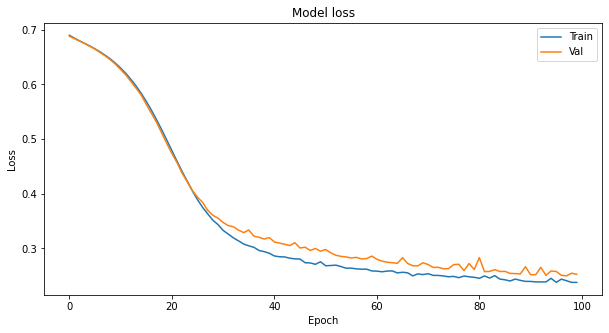

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(hist_2.history['loss'])
plt.plot(hist_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

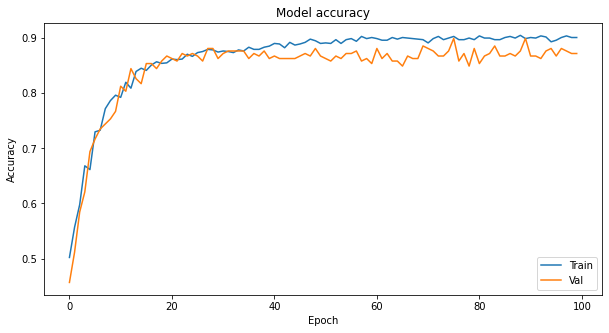

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(hist_2.history['accuracy'])
plt.plot(hist_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [ ]:
def gradient(model, x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        loss = model(x_tensor)
    return t.gradient(loss, x_tensor).numpy()
l = gradient(model_22 , X_train)
grad = []
for i in l :
  grad.append(np.linalg.norm(i))

Text(0.5, 1.0, 'Density curve of norm of SGD')

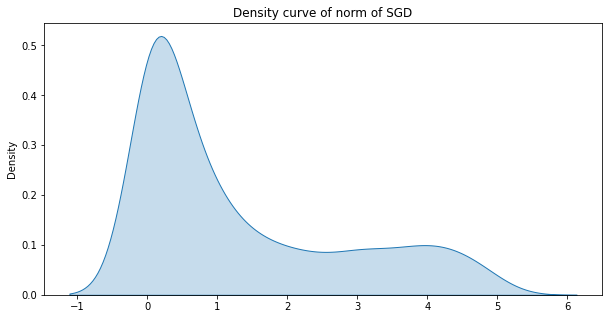

In [ ]:
plt.figure(figsize = (10,5))
sns.kdeplot(grad , fill=True)
plt.title("Density curve of norm of SGD")

In [ ]:
model_22.evaluate(X_test, Y_test)

7/7 [==============================] - 0s 8ms/step - loss: 0.2554 - accuracy: 0.8858


[0.2553914785385132, 0.8858447670936584]

In [ ]:
pd.DataFrame(np.array([["Model 1","SGD" ,0.2515,0.8982,0.3291,0.8584 , 0.9086 ,125]
                       ,["Model 1","RMSprop",0.2010 ,0.9159 ,0.2483 ,0.9041,0.88584,40],
                        ["Model 1", "ADAM",0.1896 ,0.9207 ,0.2799 ,0.8904 , 0.8858,19],["Model 1", "ADAGRAD",0.3980 ,0.8581 ,0.4111 ,0.8630 ,0.8683,140],
                       ["Model 2","ADAM" , 0.1745, 0.9276 ,0.3820 ,0.8539,0.876712,66],
                       ["Model 2","ADAGRAD" ,0.1414 ,0.9423, 0.2676 , 0.8858 ,0.8868,60],
                        ["Model 2","SGD" ,0.2377 , 0.9012 ,0.2526 ,0.8721,0.8988 ,80]
                       ]) ,columns=['Model', 'Method', 'Training Loss' ,'Training Accuracy','Validation Loss','Validation Accuracy','Test Accuracy',"Stable"])

Model   Method Training Loss  ... Validation Accuracy Test Accuracy Stable
0  Model 1      SGD        0.2515  ...              0.8584        0.9086    125
1  Model 1  RMSprop         0.201  ...              0.9041       0.88584     40
2  Model 1     ADAM        0.1896  ...              0.8904        0.8858     19
3  Model 1  ADAGRAD         0.398  ...               0.863        0.8683    140
4  Model 2     ADAM        0.1745  ...              0.8539      0.876712     66
5  Model 2  ADAGRAD        0.1414  ...              0.8858        0.8868     60
6  Model 2      SGD        0.2377  ...              0.8721        0.8988     80

[7 rows x 8 columns]

To address the overfitting we see in Model 2, we'll incorporate L2 regularization and dropout in our third model here (Model 3).

In [ ]:
model_3 = Sequential([
    Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(10,)),
    Dropout(0.3),
    Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)),
])

In [ ]:
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
hist_3 = model_3.fit(X_train, Y_train,
          batch_size=32, epochs=100,
          validation_data=(X_val, Y_val))

Epoch 1/100
32/32 [==============================] - 3s 52ms/step - loss: 14.2362 - accuracy: 0.6272 - val_loss: 3.9293 - val_accuracy: 0.6667
Epoch 2/100
32/32 [==============================] - 1s 45ms/step - loss: 1.6564 - accuracy: 0.8503 - val_loss: 0.6667 - val_accuracy: 0.8493
Epoch 3/100
32/32 [==============================] - 1s 46ms/step - loss: 0.5644 - accuracy: 0.8689 - val_loss: 0.5377 - val_accuracy: 0.8630
Epoch 4/100
32/32 [==============================] - 1s 46ms/step - loss: 0.5263 - accuracy: 0.8659 - val_loss: 0.5013 - val_accuracy: 0.8539
Epoch 5/100
32/32 [==============================] - 1s 46ms/step - loss: 0.5143 - accuracy: 0.8493 - val_loss: 0.4936 - val_accuracy: 0.8767
Epoch 6/100
32/32 [==============================] - 1s 46ms/step - loss: 0.4852 - accuracy: 0.8757 - val_loss: 0.4703 - val_accuracy: 0.8630
Epoch 7/100
32/32 [==============================] - 1s 45ms/step - loss: 0.4650 - accuracy: 0.8796 - val_loss: 0.4937 - val_accuracy: 0.8493
Epoch

We'll now plot the loss and accuracy graphs for Model 3. You'll notice that the loss is a lot higher at the start, and that's because we've changed our loss function. To plot such that the window is zoomed in between 0 and 1.2 for the loss, we add an additional line of code (plt.ylim) when plotting

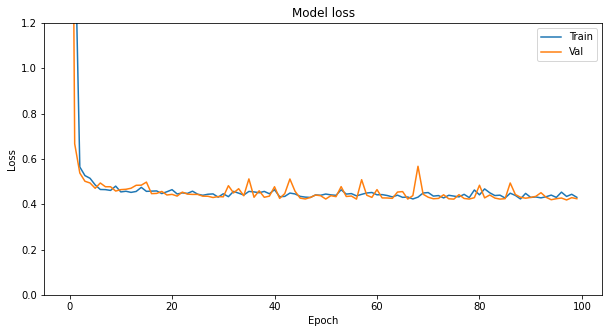

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(hist_3.history['loss'])
plt.plot(hist_3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylim(top=1.2, bottom=0)
plt.show()

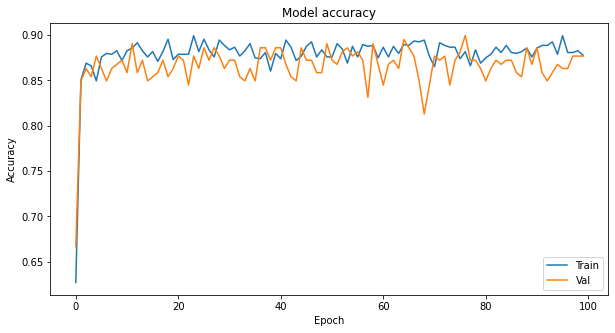

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(hist_3.history['accuracy'])
plt.plot(hist_3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [ ]:
def gradient(model, x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        loss = model(x_tensor)
    return t.gradient(loss, x_tensor).numpy()
l = gradient(model_3 , X_train)
grad = []
for i in l :
  grad.append(np.linalg.norm(i))

Text(0.5, 1.0, 'Density curve of norm of ADAM')

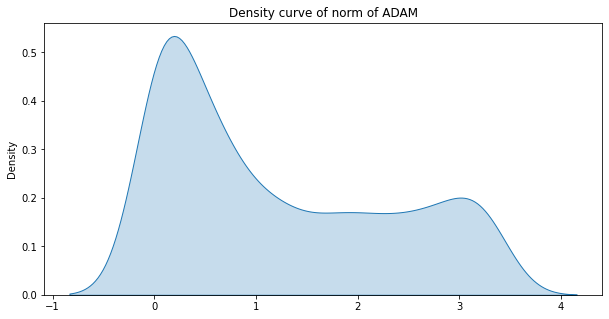

In [ ]:
plt.figure(figsize = (10,5))
sns.kdeplot(grad , fill=True)
plt.title("Density curve of norm of ADAM")

In [ ]:
model_3.evaluate(X_test, Y_test)

7/7 [==============================] - 0s 11ms/step - loss: 0.4128 - accuracy: 0.8858


[0.41281989216804504, 0.8858447670936584]

In [ ]:
model_31 = Sequential([
    Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(10,)),
    Dropout(0.3),
    Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)),
])

In [ ]:
model_31.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])
hist_3 = model_31.fit(X_train, Y_train,
          batch_size=32, epochs=200,
          validation_data=(X_val, Y_val))

Epoch 1/200
32/32 [==============================] - 2s 48ms/step - loss: 30.7263 - accuracy: 0.4932 - val_loss: 30.5249 - val_accuracy: 0.4932
Epoch 2/200
32/32 [==============================] - 1s 41ms/step - loss: 30.3416 - accuracy: 0.5294 - val_loss: 30.1430 - val_accuracy: 0.6849
Epoch 3/200
32/32 [==============================] - 1s 40ms/step - loss: 29.9622 - accuracy: 0.5479 - val_loss: 29.7662 - val_accuracy: 0.5388
Epoch 4/200
32/32 [==============================] - 1s 41ms/step - loss: 29.5893 - accuracy: 0.5587 - val_loss: 29.3946 - val_accuracy: 0.5799
Epoch 5/200
32/32 [==============================] - 1s 41ms/step - loss: 29.2200 - accuracy: 0.5978 - val_loss: 29.0278 - val_accuracy: 0.6484
Epoch 6/200
32/32 [==============================] - 1s 40ms/step - loss: 28.8553 - accuracy: 0.6184 - val_loss: 28.6658 - val_accuracy: 0.6895
Epoch 7/200
32/32 [==============================] - 1s 41ms/step - loss: 28.4965 - accuracy: 0.6360 - val_loss: 28.3085 - val_accuracy:

In [ ]:
hist_3.history['loss']

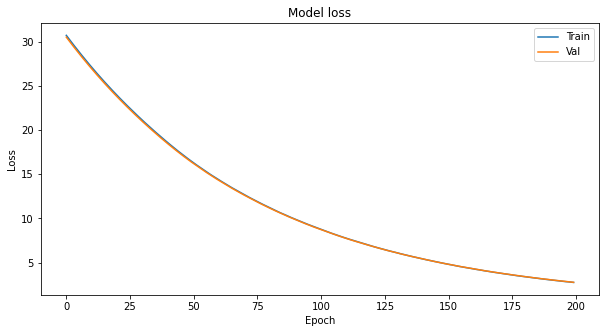

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(hist_3.history['loss'])
plt.plot(hist_3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')

plt.show()

In [ ]:
def gradient(model, x):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        loss = model(x_tensor)
    return t.gradient(loss, x_tensor).numpy()
l = gradient(model_31 , X_train)
grad = []
for i in l :
  grad.append(np.linalg.norm(i))


Text(0.5, 1.0, 'Density curve of norm of SGD')

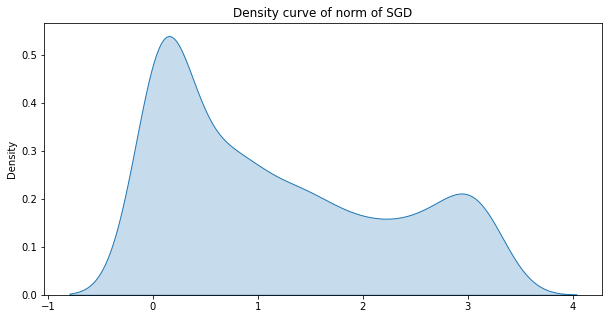

In [ ]:
plt.figure(figsize = (10,5))
sns.kdeplot(grad , fill=True)
plt.title("Density curve of norm of SGD")

In [ ]:
model_31.evaluate(X_test, Y_test)

7/7 [==============================] - 0s 12ms/step - loss: 2.7308 - accuracy: 0.8676


[2.7308108806610107, 0.8675799369812012]

As compared to Model 2, you should see that there's less overfitting!

In [ ]:
 pd.DataFrame(np.array([["Model 1","SGD" ,0.2515,0.8982,0.3291,0.8584 , 0.9086],
                        ["Model 1","RMSprop",0.2010 ,0.9159 ,0.2483 ,0.9041,0.88584], ["Model 1", "ADAM",0.1896 ,0.9207 ,0.2799 ,0.8904 , 0.8858]
                        , ["Model 1", "ADAGRAD",0.3980 ,0.8581 ,0.4111 ,0.8630 ,0.8683],["Model 2","ADAM" , 0.1745, 0.9276 ,0.3820 ,0.8539,0.876712]
                        ,["Model 2","ADAGRAD" ,0.1414 ,0.9423, 0.2676 , 0.8858 ,0.8868],
                        ["Model 2","SGD" ,0.2377 , 0.9012 ,0.2526 ,0.8721,0.8988],
                        ["Model 3","SGD" ,0.7536 ,0.8924 , 2.7692, 0.8813,0.8675], ["Model 3","ADAM" , 0.4304,0.8777 ,0.4242 ,0.8767,0.8847]]),
                   columns=['Model', 'Method', 'Training Loss' ,'Training Accuracy','Validation Loss','Validation Accuracy','Test Accuracy'])

Model   Method  ... Validation Accuracy Test Accuracy
0  Model 1      SGD  ...              0.8584        0.9086
1  Model 1  RMSprop  ...              0.9041       0.88584
2  Model 1     ADAM  ...              0.8904        0.8858
3  Model 1  ADAGRAD  ...               0.863        0.8683
4  Model 2     ADAM  ...              0.8539      0.876712
5  Model 2  ADAGRAD  ...              0.8858        0.8868
6  Model 2      SGD  ...              0.8721        0.8988
7  Model 3      SGD  ...              0.8813        0.8675
8  Model 3     ADAM  ...              0.8767        0.8847

[9 rows x 7 columns]

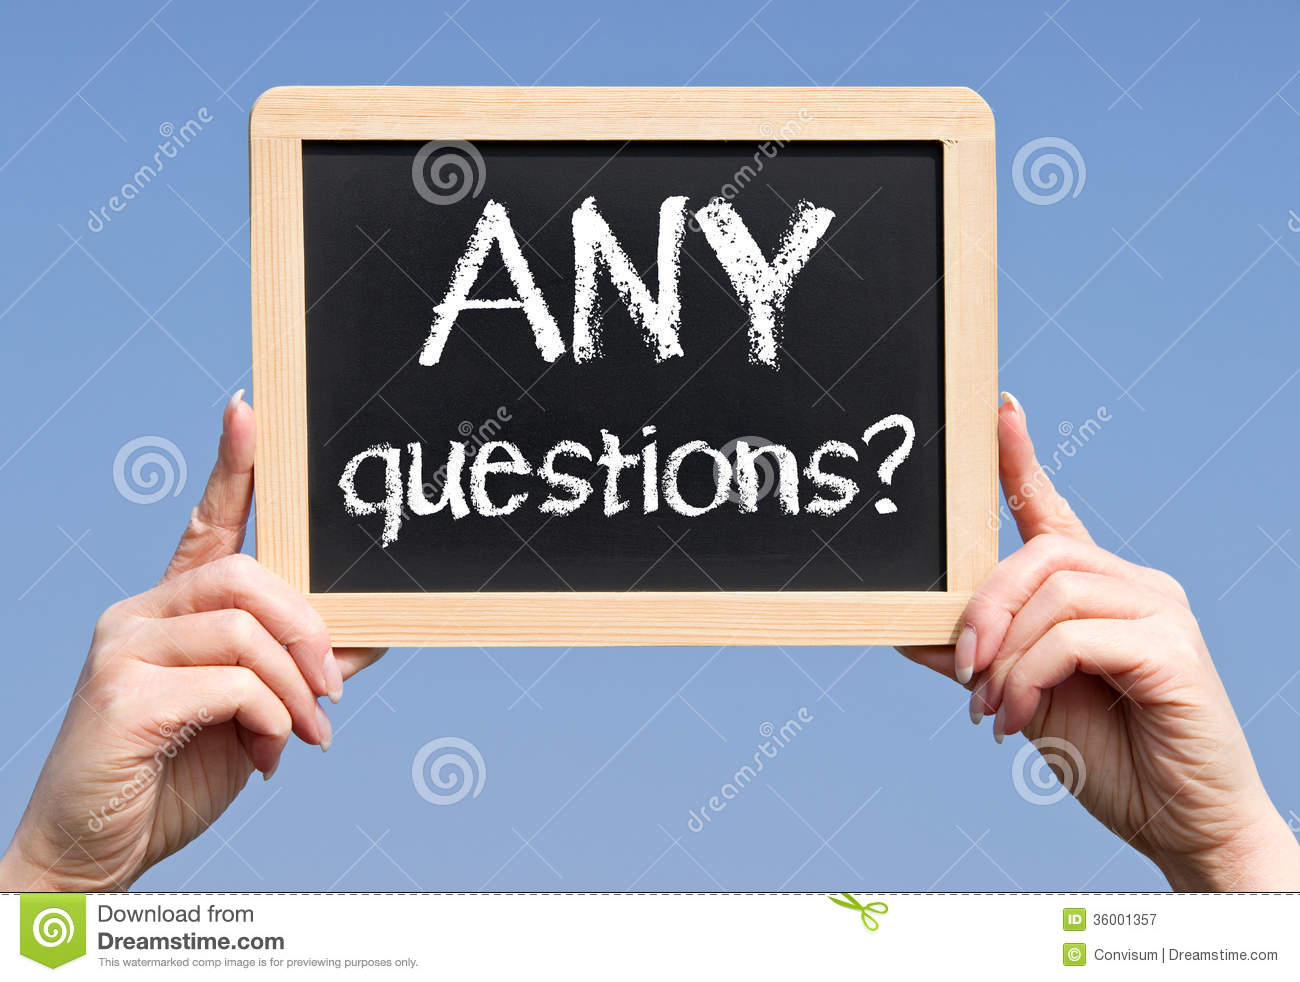